In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# Load the dataset
data = pd.read_csv('synthetic_vlsi_drc_data.csv')

# Ensure 'target' is the last column if it's not
if 'target' not in data.columns:
    raise ValueError("The dataset must contain a 'target' column.")

# Check for missing values and handle them if necessary
if data.isnull().sum().any():
    data = data.dropna()  # or use an alternative method to handle missing values

# Split the dataset into features and target
X = data.drop('target', axis=1)
y = data['target']

In [ ]:
# Models to evaluate
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

In [ ]:
# Collect performance metrics
results = []

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results.append({
        'model_name': model_name,
        'accuracy': accuracy,
        'predictions': y_pred
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print overall performance for each model
for model_name in models.keys():
    model_results = results_df[results_df['model_name'] == model_name]
    mean_accuracy = model_results['accuracy'].mean()
    print(f"{model_name} - Accuracy: {mean_accuracy:.4f}")

Random Forest - Accuracy: 0.8150
Logistic Regression - Accuracy: 0.8100
Support Vector Machine - Accuracy: 0.7600
K-Nearest Neighbors - Accuracy: 0.7450


In [ ]:
# Prepare the meta-learning dataset
meta_X = results_df.set_index('model_name')['accuracy'].to_frame()  # Keep as DataFrame

# Create meta_y as a binary outcome based on accuracy threshold
meta_y = np.array([1 if acc > 0.75 else 0 for acc in meta_X['accuracy']])  # Example binary outcome


In [ ]:
# Train a meta-model
meta_model = VotingClassifier(estimators=[
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Logistic Regression', LogisticRegression(max_iter=200)),
    ('Support Vector Machine', SVC(probability=True)),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5)),
], voting='soft')

# Ensure that meta_X has the correct shape for fitting
meta_X = meta_X.values.reshape(-1, 1)  # Reshape to (number of models, 1)

# Fit the meta-model
meta_model.fit(meta_X, meta_y)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(random_state=42)),
                             ('Logistic Regression',
                              LogisticRegression(max_iter=200)),
                             ('Support Vector Machine', SVC(probability=True)),
                             ('K-Nearest Neighbors', KNeighborsClassifier())],
                 voting='soft')

Random Forest Accuracy on Test Data: 0.8150
Logistic Regression Accuracy on Test Data: 0.8100
Support Vector Machine Accuracy on Test Data: 0.7600
K-Nearest Neighbors Accuracy on Test Data: 0.7450


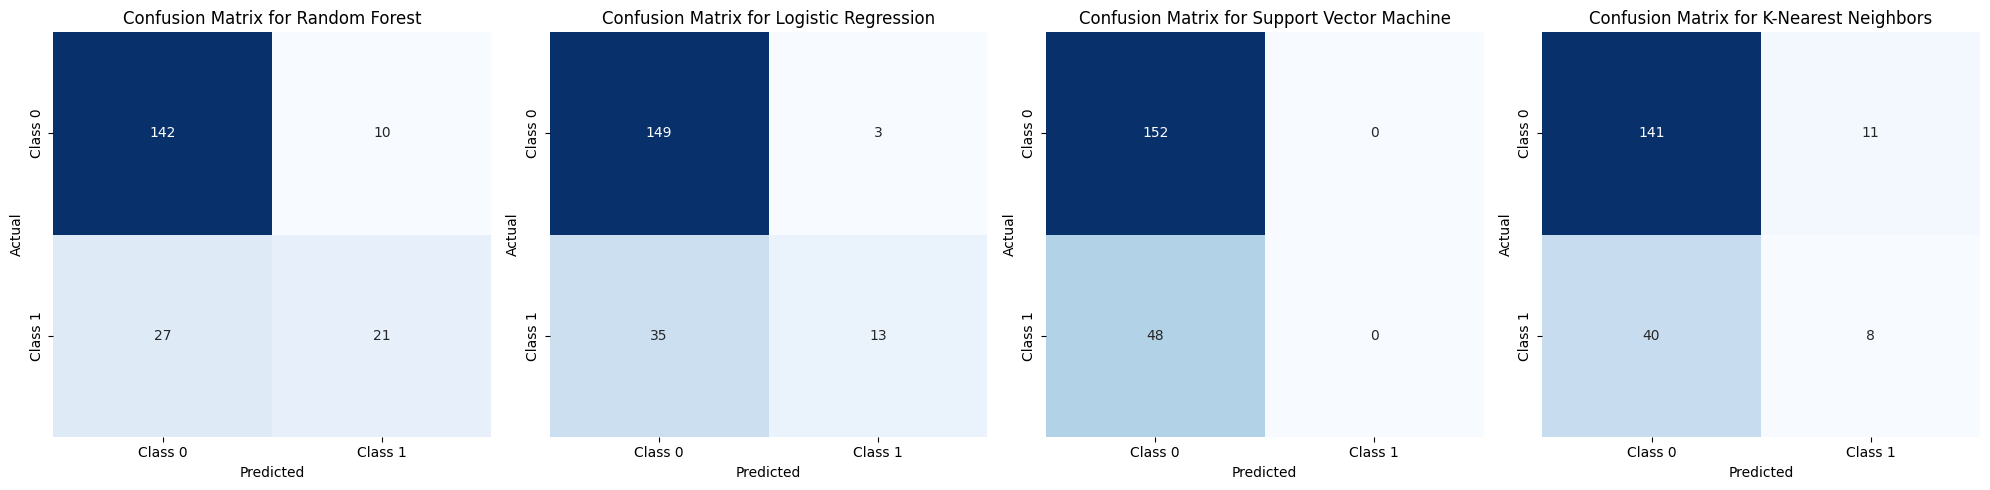

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       152
           1       0.68      0.44      0.53        48

    accuracy                           0.81       200
   macro avg       0.76      0.69      0.71       200
weighted avg       0.80      0.81      0.80       200

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       152
           1       0.81      0.27      0.41        48

    accuracy                           0.81       200
   macro avg       0.81      0.63      0.65       200
weighted avg       0.81      0.81      0.77       200

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       152
           1       0.00      0.00      0.00        48

    accuracy                           0.76 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Use the same test data for predictions from the models
# Get predictions from each model and visualize confusion matrix
best_model_name = None
best_accuracy = 0
num_models = len(models)
rows = (num_models + 3) // 4  # Calculate the number of rows needed for 4 columns

# Create a figure with subplots
fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

for idx, model_name in enumerate(models.keys()):
    preds = results_df[results_df['model_name'] == model_name]['predictions'].values[0]

    # Calculate accuracy
    accuracy = accuracy_score(y_test, preds)
    print(f"{model_name} Accuracy on Test Data: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                ax=axes[idx], xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    axes[idx].set_title(f'Confusion Matrix for {model_name}')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

    # Update best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = model_name

# Remove empty subplots if any
for empty_ax in axes[num_models:]:
    empty_ax.axis('off')

plt.tight_layout()
plt.show()

# Print classification reports
for model_name in models.keys():
    preds = results_df[results_df['model_name'] == model_name]['predictions'].values[0]
    print(f"Classification Report for {model_name}:\n{classification_report(y_test, preds)}")

print(f"\nThe best model is: {best_model_name} with accuracy: {best_accuracy:.4f}")

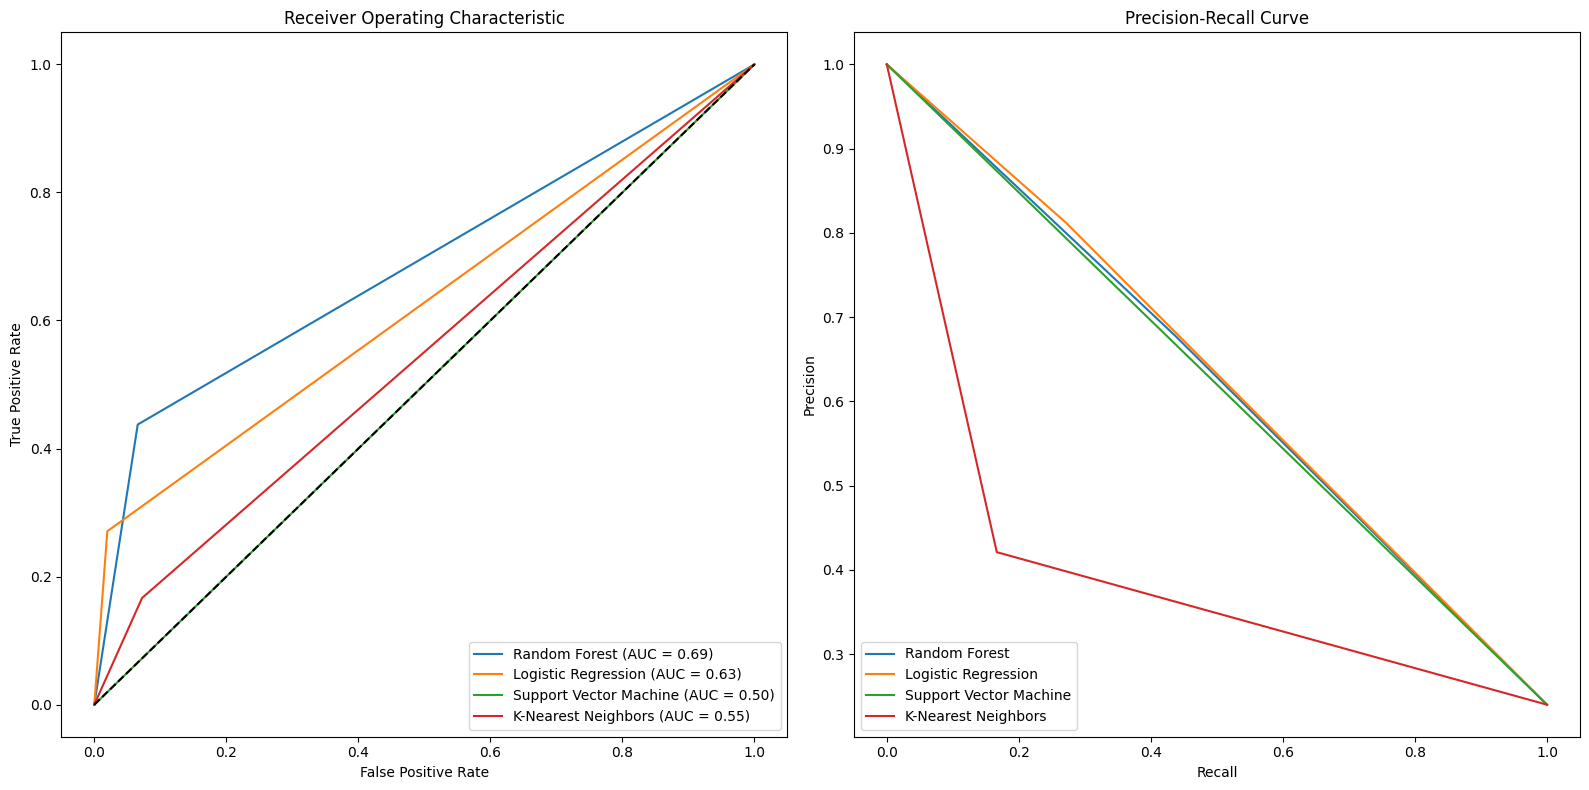

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Create a figure for ROC and Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for model_name in models.keys():
    preds = results_df[results_df['model_name'] == model_name]['predictions'].values[0]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, preds)
    axes[1].plot(recall, precision, label=model_name)

# Customize ROC plot
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title('Receiver Operating Characteristic')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc='lower right')

# Customize Precision-Recall plot
axes[1].set_title('Precision-Recall Curve')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left')

plt.tight_layout()
plt.show()

In [ ]:
print(f"\nThe best model is: {best_model_name} with accuracy: {best_accuracy:.4f}")


The best model is: Random Forest with accuracy: 0.8150


In [ ]:
from joblib import dump, load

# After training your model
best_model = models[best_model_name]  # Replace with your actual model object

# Save the model to a file
dump(best_model, 'best_model.joblib')

['best_model.joblib']

In [ ]:
dump(meta_model, 'meta_model.joblib')
print("Meta-model saved as 'meta_model.joblib'")

Meta-model saved as 'meta_model.joblib'
